In [2]:
#importando bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from prince import FAMD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# setting up plot style 
style.use('seaborn-poster')
plt.style.use('fivethirtyeight')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)


In [2]:
#import dataset

df = pd.read_csv('../datasets/data_to_FAMD.csv')
#df.drop(columns = 'not_defined', inplace = True)
df.head()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_state,valor_frete_real,review_score,product_weight_g,product_photos_qty,boleto,credit_card,debit_card,not_defined,voucher,payment_value,payment_installments
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,SP,8.72,4,500.0,4.0,0.0,1.0,0.0,0.0,2.0,38.71,1.0
1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,BA,22.76,4,400.0,1.0,1.0,0.0,0.0,0.0,0.0,141.46,1.0
2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,GO,19.22,5,420.0,1.0,0.0,3.0,0.0,0.0,0.0,179.12,3.0
3,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,RN,27.20,5,450.0,3.0,0.0,1.0,0.0,0.0,0.0,72.20,1.0
4,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,SP,8.72,5,250.0,4.0,0.0,1.0,0.0,0.0,0.0,28.62,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96454 entries, 0 to 96453
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_purchase_timestamp       96454 non-null  object 
 1   order_approved_at              96454 non-null  object 
 2   order_delivered_carrier_date   96454 non-null  object 
 3   order_delivered_customer_date  96454 non-null  object 
 4   order_estimated_delivery_date  96454 non-null  object 
 5   customer_state                 96454 non-null  object 
 6   valor_frete_real               96454 non-null  float64
 7   review_score                   96454 non-null  int64  
 8   product_weight_g               96454 non-null  float64
 9   product_photos_qty             96454 non-null  float64
 10  boleto                         96454 non-null  float64
 11  credit_card                    96454 non-null  float64
 12  debit_card                     96454 non-null 

# Feature Engineering

## Date Columns

Add columns that are the difference between `order purchase` and anothers date columns

In [4]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])

In [5]:
df['diff_approved'] = df['order_approved_at'] - df['order_purchase_timestamp'] #diff data aprovação da compra - data da compra
df['diff_carrier'] = df['order_delivered_carrier_date'] - df['order_purchase_timestamp']
df['diff_customer'] = df['order_delivered_customer_date'] - df['order_purchase_timestamp']
df['diff_estimate'] = df['order_estimated_delivery_date'] - df['order_purchase_timestamp']
df['diff_est_del'] = df['order_estimated_delivery_date'] - df['order_delivered_customer_date']
df['diff_purchase_delivered'] = df['order_delivered_customer_date'] - df['order_purchase_timestamp']


#transforming the values in days difference
df['diff_approved']=df['diff_approved']/np.timedelta64(1,'D')
df['diff_carrier']=df['diff_carrier']/np.timedelta64(1,'D')
df['diff_customer']=df['diff_customer']/np.timedelta64(1,'D')
df['diff_estimate']=df['diff_estimate']/np.timedelta64(1,'D')
df['diff_est_del']=df['diff_est_del']/np.timedelta64(1,'D')
df['diff_purchase_delivered']=df['diff_purchase_delivered']/np.timedelta64(1,'D')

df.head()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_state,valor_frete_real,review_score,product_weight_g,product_photos_qty,boleto,credit_card,debit_card,not_defined,voucher,payment_value,payment_installments,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,diff_purchase_delivered
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,SP,8.72,4,500.0,4.0,0.0,1.0,0.0,0.0,2.0,38.71,1.0,0.007431,2.373924,8.436574,15.544063,7.107488,8.436574
1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,BA,22.76,4,400.0,1.0,1.0,0.0,0.0,0.0,0.0,141.46,1.0,1.279745,1.742627,13.782037,19.137766,5.355729,13.782037
2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,GO,19.22,5,420.0,1.0,0.0,3.0,0.0,0.0,0.0,179.12,3.0,0.011505,0.216100,9.394213,26.639711,17.245498,9.394213
3,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,RN,27.20,5,450.0,3.0,0.0,1.0,0.0,0.0,0.0,72.20,1.0,0.012419,3.758252,13.208750,26.188819,12.980069,13.208750
4,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,SP,8.72,5,250.0,4.0,0.0,1.0,0.0,0.0,0.0,28.62,1.0,0.042940,0.936053,2.873877,12.112049,9.238171,2.873877


In [6]:
#drop date columns
cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
        'order_delivered_customer_date', 'order_estimated_delivery_date']

df.drop(columns = cols, axis= 1, inplace = True)
df.head()

,customer_state,valor_frete_real,review_score,product_weight_g,product_photos_qty,boleto,credit_card,debit_card,not_defined,voucher,payment_value,payment_installments,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,diff_purchase_delivered
0,SP,8.72,4,500.0,4.0,0.0,1.0,0.0,0.0,2.0,38.71,1.0,0.007431,2.373924,8.436574,15.544063,7.107488,8.436574
1,BA,22.76,4,400.0,1.0,1.0,0.0,0.0,0.0,0.0,141.46,1.0,1.279745,1.742627,13.782037,19.137766,5.355729,13.782037
2,GO,19.22,5,420.0,1.0,0.0,3.0,0.0,0.0,0.0,179.12,3.0,0.011505,0.216100,9.394213,26.639711,17.245498,9.394213
3,RN,27.20,5,450.0,3.0,0.0,1.0,0.0,0.0,0.0,72.20,1.0,0.012419,3.758252,13.208750,26.188819,12.980069,13.208750
4,SP,8.72,5,250.0,4.0,0.0,1.0,0.0,0.0,0.0,28.62,1.0,0.042940,0.936053,2.873877,12.112049,9.238171,2.873877


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96454 entries, 0 to 96453
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_state           96454 non-null  object 
 1   valor_frete_real         96454 non-null  float64
 2   review_score             96454 non-null  int64  
 3   product_weight_g         96454 non-null  float64
 4   product_photos_qty       96454 non-null  float64
 5   boleto                   96454 non-null  float64
 6   credit_card              96454 non-null  float64
 7   debit_card               96454 non-null  float64
 8   not_defined              96454 non-null  float64
 9   voucher                  96454 non-null  float64
 10  payment_value            96454 non-null  float64
 11  payment_installments     96454 non-null  float64
 12  diff_approved            96454 non-null  float64
 13  diff_carrier             96454 non-null  float64
 14  diff_customer         

## Customer and Seller state

In [8]:
#create a regions list
norte = ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
nordeste = ['MA', 'PI', 'CE', 'RN', 'PE', 'PB', 'SE', 'AL', 'BA']
centro_oeste = ['MT', 'MS', 'GO']
sul = ['PR', 'RS', 'SC']
sudeste = ['SP', 'RJ', 'ES', 'MG']

In [9]:
#create a new feature based in region list
def region (row):
    val = ""
    if row['customer_state'] in norte:
        val = 'norte'
    elif row['customer_state'] in nordeste:
        val = 'nordeste'
    elif row['customer_state'] in centro_oeste:
        val = 'centro_oeste'
    elif row['customer_state'] in sul:
        val = 'sul'
    elif row['customer_state'] in sudeste:
        val = 'sudeste'
    return val

In [10]:
df['customer_region'] = df.apply(region, axis = 1)

In [11]:
#drop the customer_state colum
df.drop(columns = 'customer_state', axis = 1, inplace = True)
df.head()

,valor_frete_real,review_score,product_weight_g,product_photos_qty,boleto,credit_card,debit_card,not_defined,voucher,payment_value,payment_installments,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,diff_purchase_delivered,customer_region
0,8.72,4,500.0,4.0,0.0,1.0,0.0,0.0,2.0,38.71,1.0,0.007431,2.373924,8.436574,15.544063,7.107488,8.436574,sudeste
1,22.76,4,400.0,1.0,1.0,0.0,0.0,0.0,0.0,141.46,1.0,1.279745,1.742627,13.782037,19.137766,5.355729,13.782037,nordeste
2,19.22,5,420.0,1.0,0.0,3.0,0.0,0.0,0.0,179.12,3.0,0.011505,0.216100,9.394213,26.639711,17.245498,9.394213,centro_oeste
3,27.20,5,450.0,3.0,0.0,1.0,0.0,0.0,0.0,72.20,1.0,0.012419,3.758252,13.208750,26.188819,12.980069,13.208750,nordeste
4,8.72,5,250.0,4.0,0.0,1.0,0.0,0.0,0.0,28.62,1.0,0.042940,0.936053,2.873877,12.112049,9.238171,2.873877,sudeste


## Applying FAMD

In [12]:
famd = FAMD(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
)

famd.fit(df)
famd_components = famd.transform(df)
famd_components.head()


,0,1
0,-1.089776,0.133053
1,1.740006,1.213387
2,1.011831,-0.495000
3,1.811713,1.265369
4,-1.379788,-0.025633


ax = famd.plot_row_coordinates(
    df,
    ax=None,
    figsize=(12, 8),
    x_component=0,
    y_component=1,
    labels = df['review_score'],
    color_labels=['Review Score {}'.format(t) for t in df['review_score']],
    ellipse_outline=False,
    ellipse_fill=True,
    show_points=True
)



Text(0, 0.5, 'Inertia')

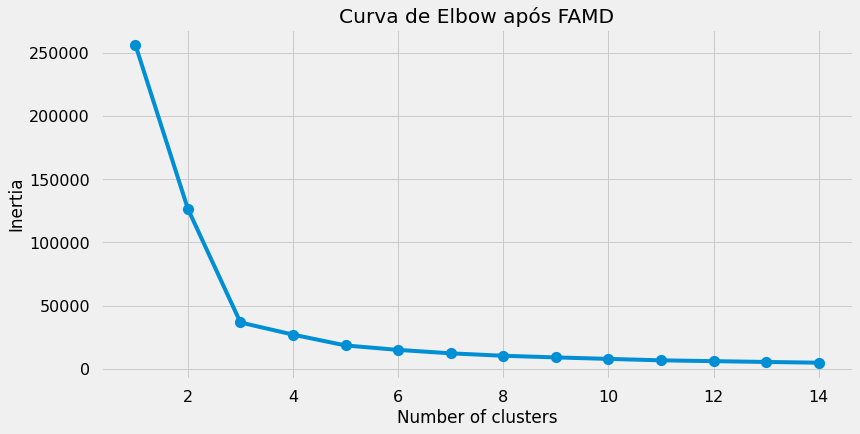

In [13]:

sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(famd_components)
    sse.append([k, km.inertia_])
    
famd_n_cluster = pd.DataFrame({'n_cluster': range(1,15), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Curva de Elbow após FAMD')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [26]:
#applying kmeans in FAMD components

kmeans_famd = KMeans(n_clusters=3,
                     n_init=10, max_iter=300,
                     init='k-means++', 
                     random_state=42)

kmeans_famd.fit_predict(famd_components)

array([0, 2, 3, ..., 2, 3, 1])

In [27]:
print('KMeans - FAMD Silhouette Score: {}'.format(silhouette_score(famd_components, kmeans_famd.labels_, metric='euclidean')))
labels_famd = kmeans_famd.labels_
clusters_famd = pd.concat([famd_components, pd.DataFrame({'famd_clusters':labels_famd})], axis=1)
clusters_famd

KMeans - FAMD Silhouette Score: 0.6845296517575453


,0,1,famd_clusters
0,-1.089776,0.133053,0
1,1.740006,1.213387,2
2,1.011831,-0.495000,3
3,1.811713,1.265369,2
4,-1.379788,-0.025633,0
...,...,...,...
96449,-0.988745,0.165224,0
96450,-0.269498,0.547945,0
96451,2.809770,1.876557,2
96452,0.150577,0.689908,3


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


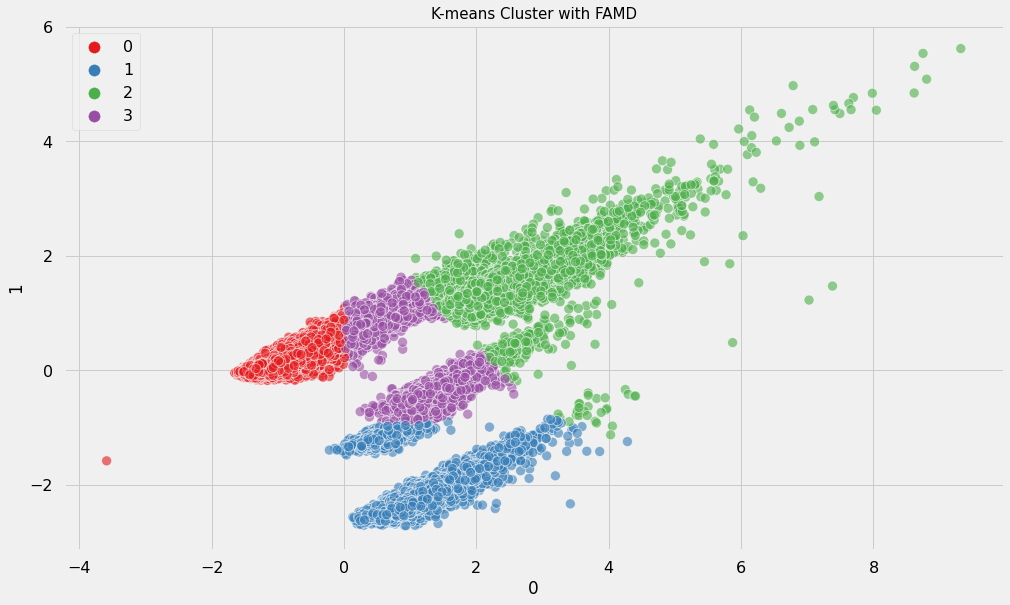

In [28]:
plt.figure(figsize = (12,8))
sns.scatterplot(clusters_famd.iloc[:,0],clusters_famd.iloc[:,1],hue=clusters_famd['famd_clusters'], 
                palette='Set1', s=100, alpha=0.6).set_title('K-means Cluster with FAMD', fontsize=15)
plt.legend()
plt.show()

In [29]:
clusters_famd['famd_clusters'].value_counts()

0    61943
1    15317
2    11385
3     7809
Name: famd_clusters, dtype: int64

In [22]:
cluster_famd_profile = pd.merge(df, clusters_famd['famd_clusters'], left_index=True, right_index=True )
cluster_famd_profile.head()

,valor_frete_real,review_score,product_weight_g,product_photos_qty,boleto,credit_card,debit_card,not_defined,voucher,payment_value,payment_installments,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,diff_purchase_delivered,customer_region,famd_clusters
0,8.72,4,500.0,4.0,0.0,1.0,0.0,0.0,2.0,38.71,1.0,0.007431,2.373924,8.436574,15.544063,7.107488,8.436574,sudeste,1
1,22.76,4,400.0,1.0,1.0,0.0,0.0,0.0,0.0,141.46,1.0,1.279745,1.742627,13.782037,19.137766,5.355729,13.782037,nordeste,0
2,19.22,5,420.0,1.0,0.0,3.0,0.0,0.0,0.0,179.12,3.0,0.011505,0.216100,9.394213,26.639711,17.245498,9.394213,centro_oeste,2
3,27.20,5,450.0,3.0,0.0,1.0,0.0,0.0,0.0,72.20,1.0,0.012419,3.758252,13.208750,26.188819,12.980069,13.208750,nordeste,0
4,8.72,5,250.0,4.0,0.0,1.0,0.0,0.0,0.0,28.62,1.0,0.042940,0.936053,2.873877,12.112049,9.238171,2.873877,sudeste,1


In [2]:
cluster_famd_profile.to_csv("cluster_famd_profile.csv", index = False)

NameError: name 'cluster_famd_profile' is not defined

In [3]:
cluster_famd_profile = pd.read_csv('cluster_famd_profile.csv',
                                  dtype = ({"review_score": str})
                                  )
cluster_famd_profile.head()

,valor_frete_real,review_score,product_weight_g,product_photos_qty,boleto,credit_card,debit_card,not_defined,voucher,payment_value,payment_installments,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,diff_purchase_delivered,customer_region,famd_clusters
0,8.72,4,500.0,4.0,0.0,1.0,0.0,0.0,2.0,38.71,1.0,0.007431,2.373924,8.436574,15.544063,7.107488,8.436574,sudeste,1
1,22.76,4,400.0,1.0,1.0,0.0,0.0,0.0,0.0,141.46,1.0,1.279745,1.742627,13.782037,19.137766,5.355729,13.782037,nordeste,0
2,19.22,5,420.0,1.0,0.0,3.0,0.0,0.0,0.0,179.12,3.0,0.011505,0.216100,9.394213,26.639711,17.245498,9.394213,centro_oeste,2
3,27.20,5,450.0,3.0,0.0,1.0,0.0,0.0,0.0,72.20,1.0,0.012419,3.758252,13.208750,26.188819,12.980069,13.208750,nordeste,0
4,8.72,5,250.0,4.0,0.0,1.0,0.0,0.0,0.0,28.62,1.0,0.042940,0.936053,2.873877,12.112049,9.238171,2.873877,sudeste,1


In [10]:
cluster_famd_profile['famd_clusters'].value_counts()

1    65103
2    18458
0    12893
Name: famd_clusters, dtype: int64

In [4]:
cluster_famd_profile.columns

Index(['valor_frete_real', 'review_score', 'product_weight_g', 'product_photos_qty', 'boleto', 'credit_card', 'debit_card', 'not_defined', 'voucher', 'payment_value', 'payment_installments', 'diff_approved', 'diff_carrier', 'diff_customer', 'diff_estimate', 'diff_est_del', 'diff_purchase_delivered', 'customer_region', 'famd_clusters'], dtype='object')

## EDA Clusters

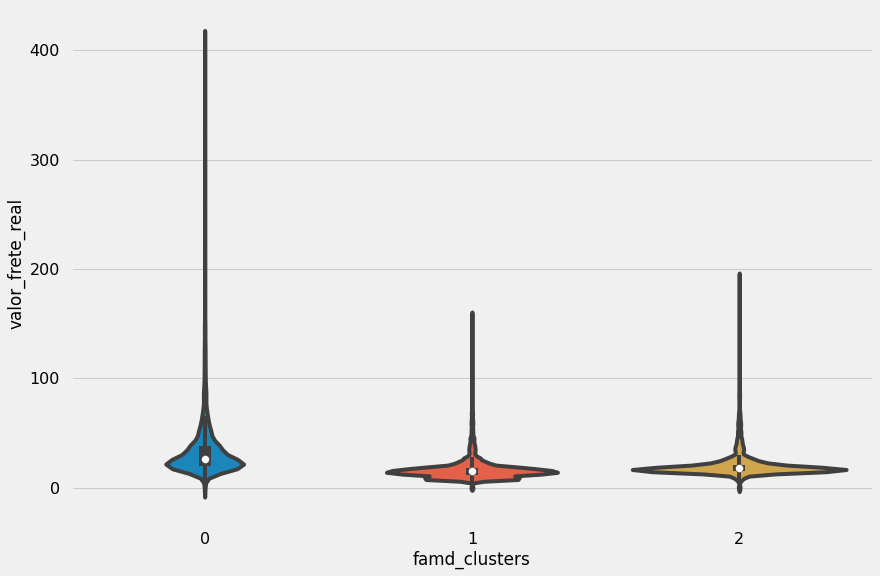

In [5]:
sns.violinplot(x = 'famd_clusters', y = 'valor_frete_real', data = cluster_famd_profile)
plt.show()

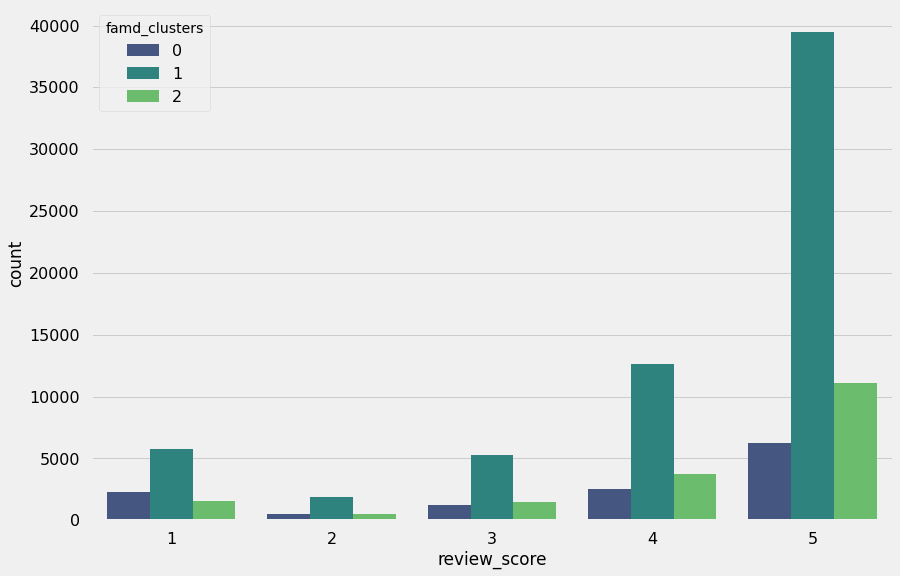

In [9]:
order = ["1", "2", "3", "4", "5"]
sns.countplot(x = 'review_score', 
             data = cluster_famd_profile,
             hue = 'famd_clusters',
             palette = 'viridis',
             order=order)


plt.show()

In [36]:
temp = cluster_famd_profile.groupby(['famd_clusters', 'review_score']).size().reset_index().\
    rename(columns = {0:'qtd'})

temp2 = temp.groupby('famd_clusters').agg({'qtd': 'sum'}).reset_index()


temp_merge = pd.merge(temp, temp2, how = 'left', on = 'famd_clusters')
temp_merge['pct_cluster'] = round(temp_merge['qtd_x']/temp_merge['qtd_y']*100,2)

,famd_clusters,review_score,qtd_x,qtd_y,pct_cluster
0,0,1,2283,12893,17.71
1,0,2,549,12893,4.26
2,0,3,1222,12893,9.48
3,0,4,2562,12893,19.87
4,0,5,6277,12893,48.69
5,1,1,5796,65103,8.90
6,1,2,1899,65103,2.92
7,1,3,5291,65103,8.13
8,1,4,12605,65103,19.36
9,1,5,39512,65103,60.69


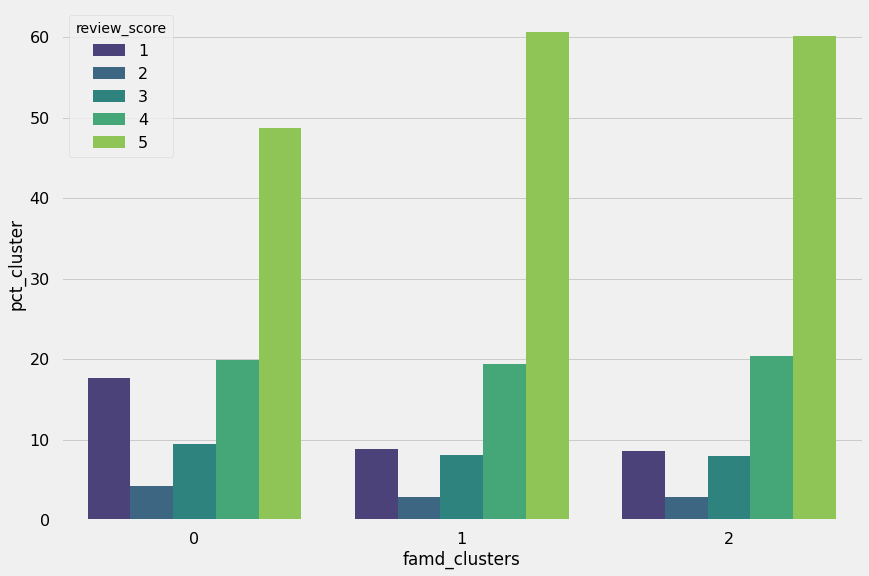

In [40]:
#order = ["0", "1", "2"]
sns.barplot(x = 'famd_clusters',
            y = 'pct_cluster',
             data = temp_merge,
             hue = 'review_score',
             palette = 'viridis')


plt.show()

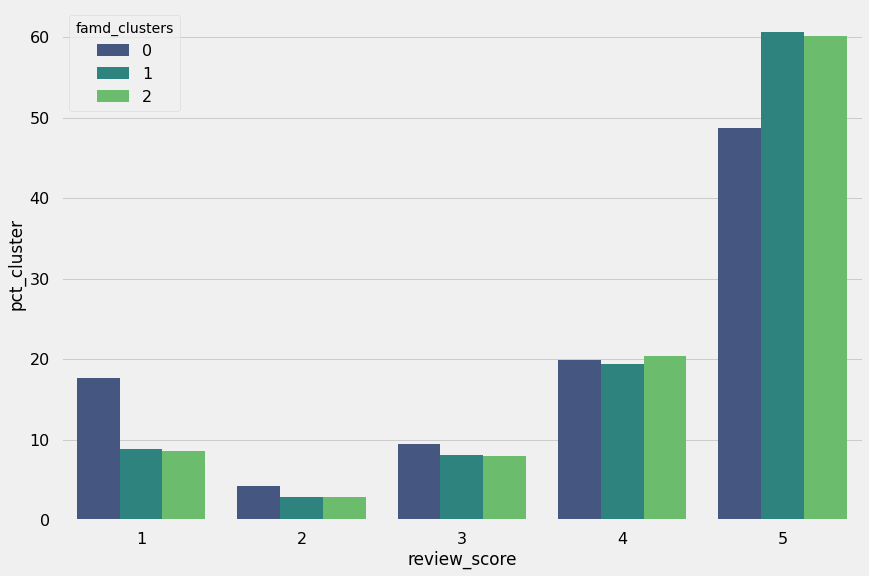

In [41]:
sns.barplot(x = 'review_score',
            y = 'pct_cluster',
             data = temp_merge,
             hue = 'famd_clusters',
             palette = 'viridis')


plt.show()

In [42]:
cluster_famd_profile.columns

Index(['valor_frete_real', 'review_score', 'product_weight_g', 'product_photos_qty', 'boleto', 'credit_card', 'debit_card', 'not_defined', 'voucher', 'payment_value', 'payment_installments', 'diff_approved', 'diff_carrier', 'diff_customer', 'diff_estimate', 'diff_est_del', 'diff_purchase_delivered', 'customer_region', 'famd_clusters'], dtype='object')

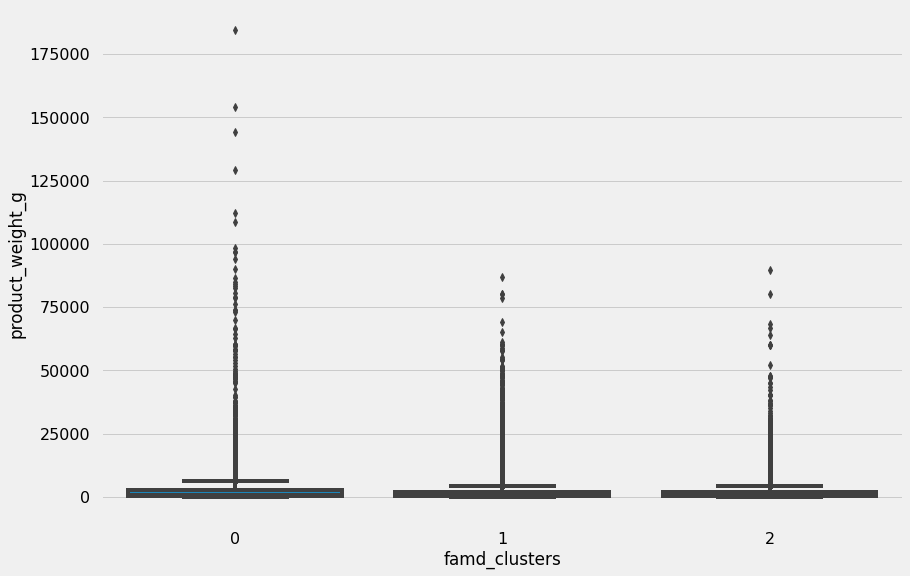

In [59]:
sns.boxplot(x = 'famd_clusters', 
            y = 'product_weight_g', 
            data = cluster_famd_profile)
plt.show()

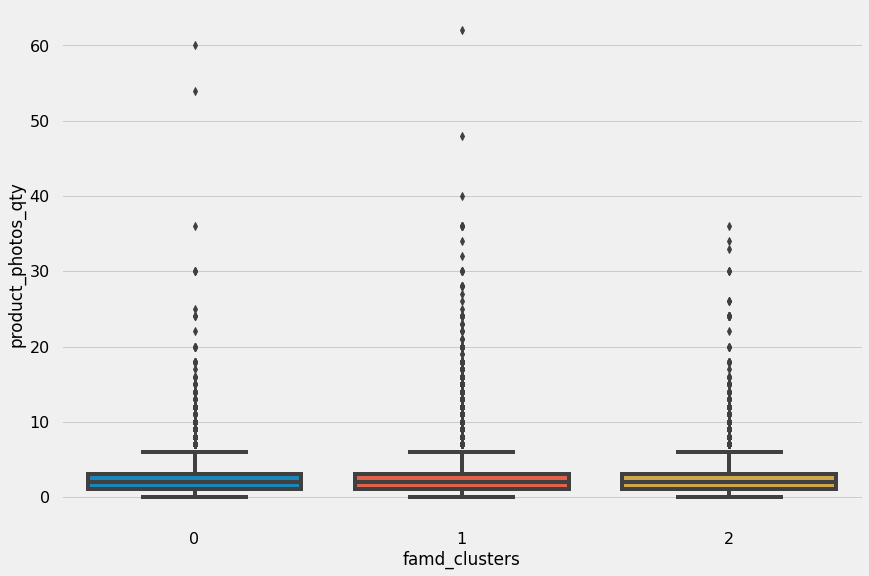

In [46]:
sns.boxplot(x = 'famd_clusters', 
            y = 'product_photos_qty', 
            data = cluster_famd_profile)
plt.show()

In [55]:
cluster_type_payment = cluster_famd_profile.groupby('famd_clusters').agg({'boleto':'sum',
                                                   'credit_card':'sum',
                                                   'debit_card':'sum',
                                                   'not_defined':'sum',
                                                   'voucher':'sum'}).reset_index()

cluster_type_payment = cluster_type_payment.melt(id_vars=['famd_clusters'],
                          value_vars=['boleto', 'credit_card', 'debit_card', 'voucher'])
cluster_type_payment

,famd_clusters,variable,value
0,0,boleto,2345.0
1,1,boleto,12506.0
2,2,boleto,4326.0
3,0,credit_card,45420.0
4,1,credit_card,167656.0
5,2,credit_card,48051.0
6,0,debit_card,169.0
7,1,debit_card,1074.0
8,2,debit_card,242.0
9,0,voucher,790.0


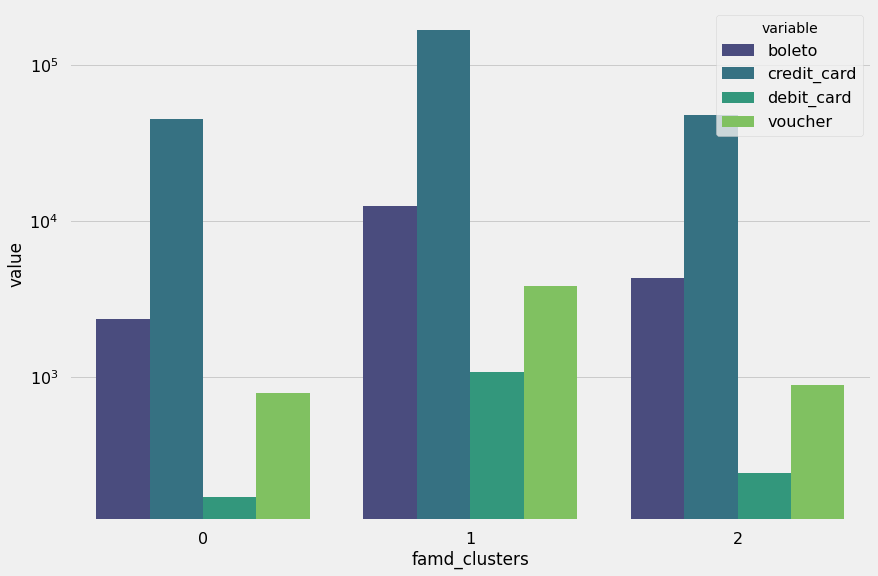

In [62]:
sns.barplot(x = 'famd_clusters',
            y = 'value',
            data = cluster_type_payment,
            hue = 'variable',
            palette = 'viridis',
            log = True)

plt.show()

In [63]:
cluster_famd_profile.columns

Index(['valor_frete_real', 'review_score', 'product_weight_g', 'product_photos_qty', 'boleto', 'credit_card', 'debit_card', 'not_defined', 'voucher', 'payment_value', 'payment_installments', 'diff_approved', 'diff_carrier', 'diff_customer', 'diff_estimate', 'diff_est_del', 'diff_purchase_delivered', 'customer_region', 'famd_clusters'], dtype='object')

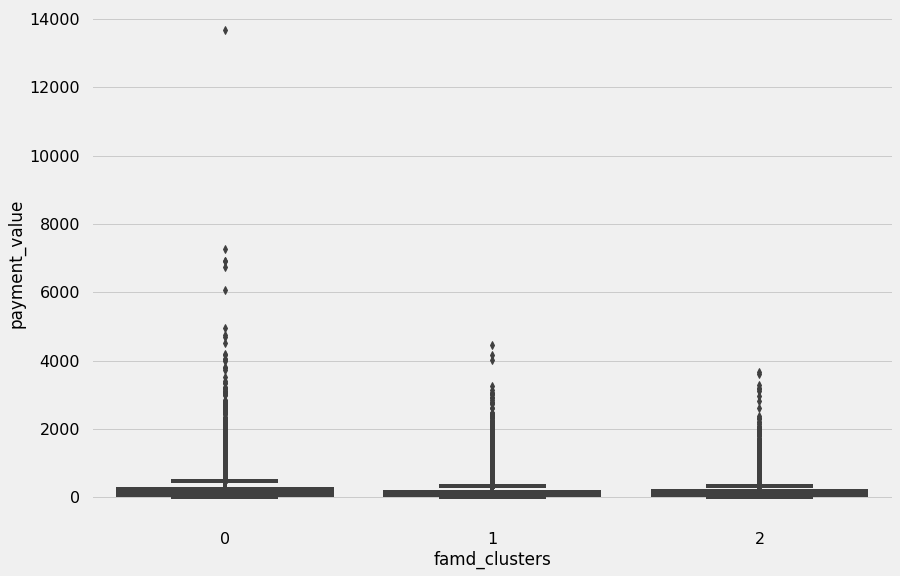

In [64]:
sns.boxplot(x = 'famd_clusters', y = 'payment_value' ,data = cluster_famd_profile)
plt.show()

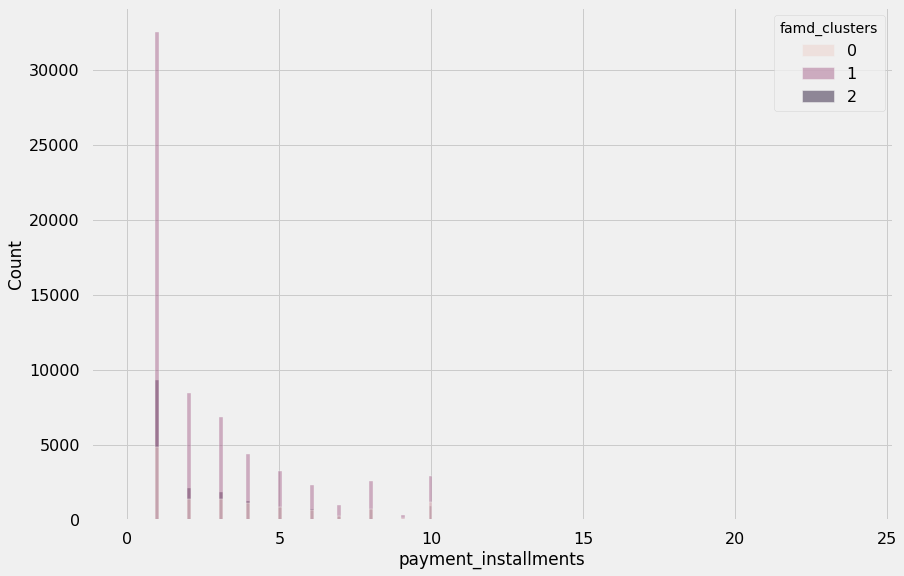

In [66]:
sns.histplot(x = 'payment_installments',
             data = cluster_famd_profile,
             hue ='famd_clusters')

plt.show()

In [67]:
customer_region = cluster_famd_profile.groupby(['famd_clusters','customer_region']).\
    size().\
    reset_index().\
    rename(columns = {0: 'qtd'})

customer_region['pct'] = round(customer_region['qtd']/ customer_region['qtd'].sum() * 100,2)
customer_region.sort_values(['famd_clusters', 'pct'], ascending = [True, False])
customer_region

,famd_clusters,customer_region,qtd,pct
0,0,centro_oeste,915,0.97
1,0,nordeste,9042,9.58
2,0,norte,1796,1.90
3,0,sudeste,1079,1.14
4,0,sul,28,0.03
5,1,centro_oeste,2,0.00
6,1,sudeste,65101,68.98
7,2,centro_oeste,2627,2.78
8,2,sudeste,1,0.00
9,2,sul,13783,14.60


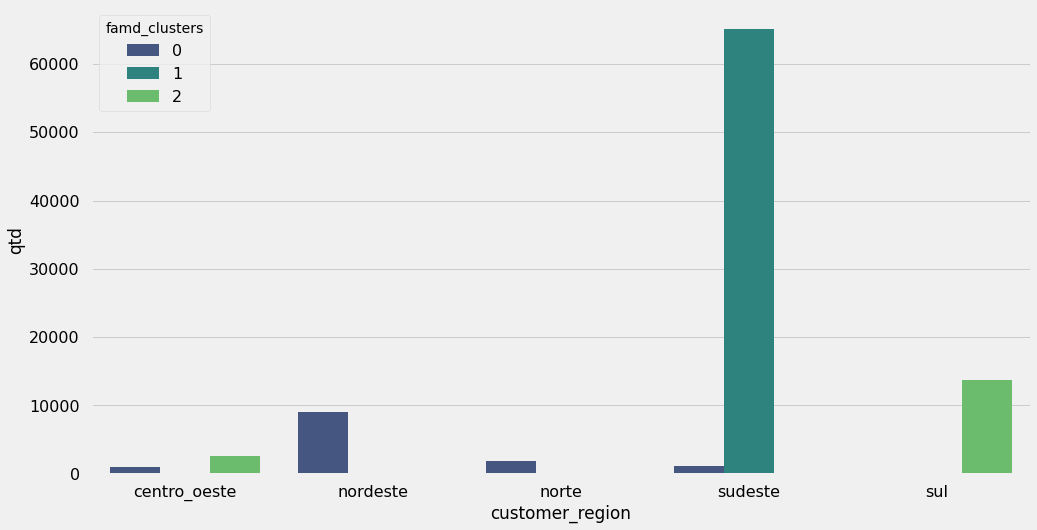

In [68]:
plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'customer_region', y = 'qtd', 
                 data = customer_region, 
                 hue = 'famd_clusters',
                 palette = 'viridis')
plt.show()